In [2]:
import glob

import pandas as pd
from llavaguard.taxonomy.PEGI.PEGI_Graph import get_content_categories, get_content_categories_with_numbers, policy_graph
from PIL import Image
from llavaguard.taxonomy.policy_config import local_image_dirs, local_data_dir
from llavaguard.taxonomy.PEGI.PEGI_Graph import get_policy_intro, policy_graph_to_safety_policy
import random
from itertools import product
import os
import pandas as pd
from llavaguard.taxonomy.PEGI.PEGI_Graph import remove_mutually_exclusive_categories
import matplotlib.pyplot as plt
import seaborn as sns
from llavaguard.taxonomy.PEGI.PEGI_Graph import get_majority_vote_from_df, remove_mutually_exclusive_categories_df



def calculate_metrics(human_feedback, model_predictions, categories_with_numbers):
    """
    Calculate classification metrics comparing human feedback to model predictions
    
    Args:
        human_feedback (pd.DataFrame): DataFrame with human annotations
        model_predictions (pd.DataFrame): DataFrame with model predictions
        categories_with_numbers (list): List of category column names
        
    Returns:
        dict: Dictionary containing metrics and confusion matrix values
    """
    TP, FP, TN, FN = 0, 0, 0, 0
    category_wise_confusion_matrix = {}
    human_feedback = human_feedback.sort_values('sample_id')
    model_predictions = model_predictions.sort_values('sample_id')
    for hf_row, pred_row in zip(human_feedback.iterrows(), model_predictions.iterrows()):
        hf_row = hf_row[1]
        pred_row = pred_row[1]
        assert hf_row['sample_id'] == pred_row['sample_id']
        
        hf_categories = hf_row[categories_with_numbers]
        pred_categories = pred_row[categories_with_numbers]
        
        for hf_category, pred_category, category in zip(hf_categories.values, pred_categories.values, categories_with_numbers):
            if category not in category_wise_confusion_matrix:
                category_wise_confusion_matrix[category] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
            if hf_category == 1:
                if pred_category == 1:
                    TP += 1
                    category_wise_confusion_matrix[category]['TP'] += 1
                else:
                    FN += 1
                    category_wise_confusion_matrix[category]['FN'] += 1
            else:
                if pred_category == 0:
                    TN += 1
                    category_wise_confusion_matrix[category]['TN'] += 1
                else:
                    FP += 1
                    category_wise_confusion_matrix[category]['FP'] += 1
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    balanced_accuracy = (TPR + (1 - FPR)) / 2
    
    def get_bal_acc(metrics):
        TP, FN, FP, TN = metrics['TP'], metrics['FN'], metrics['FP'], metrics['TN']
        if TP + FN == 0 or FP + TN == 0:
            return None
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.5
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.5
        return (TPR + (1 - FPR)) / 2
    category_wise_stats = []
    for category in categories_with_numbers:
        category_wise_confusion_matrix[category]['bal_acc'] = get_bal_acc(category_wise_confusion_matrix[category])
        if category_wise_confusion_matrix[category]['bal_acc'] is not None:
            category_wise_stats += [f"{category} (acc {category_wise_confusion_matrix[category]['bal_acc']:.2f})"]
    metrics = {
        'F2': round(5 * (precision * TPR) / (4 * precision + TPR), 2),
        'recall': round(TPR, 2),
        'precision': round(precision, 2),
        'accuracy': round(balanced_accuracy, 2),
        'specificity': round(specificity, 2),
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'category_wise_confusion_matrix': category_wise_confusion_matrix,
        'category_wise_stats': ', '.join(category_wise_stats)
    }
    
    return metrics


def plot_category_distirbutions(data_frame, 
                                title="Number of images per category",
                                output_path=f"{local_data_dir}/data/annotations/auto_generated_annotations/majority_vote.png"):
    plt_data = data_frame.sum()
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=plt_data.index, y=plt_data.values)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.ylabel('Number of images')
    plt.xlabel('Categories')
    plt.title(title)
    plt.savefig(output_path)
    plt.show()


def combine_all_annotations(im_paths, models, prompting_teq, annotation_dir, output_path):
    categories = get_content_categories_with_numbers(policy_graph)
    data_frame = pd.DataFrame(columns=['model', 'techinque', 'sample_id', 'im_path'] + categories)
    missing, invalid = 0, 0
    for im_path in im_paths:
        sample_path = im_path.split('images/')[-1].split('.jpg')[0]
        sample_id = im_path.split('/')[-1].split('.')[0]
        for model, t in product(models, prompting_teq):
            violations = []
            missing, invalid = 0, 0
            for category in categories_with_numbers:
                annot_path = os.path.join(annotation_dir, model.split('/')[1], t, sample_path, f"{category}.txt")
                if os.path.exists(annot_path):
                    with open(annot_path, 'r') as f:
                        content = f.read()                 
                        if 'Yes' in content:
                            violations.append(1)
                        elif 'No' in content or 'Not applicable' in content:
                            violations.append(0)
                        else:
                            invalid += 1
                            violations.append(0)
                else:
                    violations.append(0)
                    missing += 1
            if len(violations) > 0:
                data = [model.split('/')[1], t, sample_id, im_path] + violations
                frame = pd.DataFrame(columns=['model', 'techinque', 'sample_id', 'im_path'] + categories, data=[data], index=[0])
                data_frame = pd.concat([data_frame, frame])
    print(f"Missing files: {missing}, Invalid files: {invalid}")
    # save merged data on missing files and invalid files
    with open(output_path.replace('.csv', f"_meta.txt"), 'w+') as f:
        f.write(f"Missing files: {missing}, Invalid files: {invalid}, Models: {models}, Techniques: {prompting_teq}")
    # save the data frame
    data_frame.to_csv(output_path, index=False)

def apply_majority_voting(combined_annotations, out_path=None, remove_mutually_exclusive=True):
    data_frame = pd.DataFrame(columns=['voting_mechanism', 'sample_id', 'im_path'] + categories_with_numbers)
    for sample_id in combined_annotations['sample_id'].unique():
        sample_annotations = combined_annotations.loc[combined_annotations['sample_id'] == sample_id]
        for voting_mechanism in ['majority_vote', 'with_description', 'no_description']:
            if voting_mechanism == 'majority_vote':
                data = get_majority_vote_from_df(sample_annotations)
            elif voting_mechanism == 'with_description':
                data = get_majority_vote_from_df(sample_annotations[sample_annotations['techinque'] == 'prompt_for_every_content_category_describe_image2'])
            elif voting_mechanism == 'no_description':
                data = get_majority_vote_from_df(sample_annotations[sample_annotations['techinque'] == 'prompt_for_every_content_category'])
            data['voting_mechanism'] = voting_mechanism
            data['sample_id'] = sample_id
            data['im_path'] = sample_annotations['im_path'].values[0]
            data_frame = pd.concat([data_frame, data])
    if remove_mutually_exclusive:
        # remove mutually exclusive categories
        ex = remove_mutually_exclusive_categories_df(data_frame[categories_with_numbers])
        data_frame[categories_with_numbers] = ex.values

    if out_path is not None:
        data_frame.to_csv(out_path, index=False)
    return data_frame

random.seed(42)
categories_with_numbers = get_content_categories_with_numbers(policy_graph)
categories = get_content_categories(policy_graph)


models = ["OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-7B-Instruct", "Qwen/Qwen2-VL-72B-Instruct", "lmms-lab/llava-onevision-qwen2-7b-ov", "lmms-lab/llava-onevision-qwen2-72b-ov", "lmms-lab/llama3-llava-next-8b"][:]
models = ["lmms-lab/llava-onevision-qwen2-7b-ov", "lmms-lab/llava-onevision-qwen2-72b-ov", "Qwen/Qwen2-VL-7B-Instruct", "Qwen/Qwen2-VL-72B-Instruct", "OpenGVLab/InternVL2-Llama3-76B", "OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-8B"]
teq = ['prompt_for_every_content_category', 'prompt_for_every_content_category_describe_image', 'prompt_for_every_content_category_describe_image2']
path_annot = f"{local_data_dir}/data/annotations/auto_generated_annotations"
out_path_1 = f"{local_data_dir}/data/annotations/auto_generated_annotations/v0_1"
out_path_2 = f"{local_data_dir}/data/annotations/auto_generated_annotations/v0_2"
out_path = out_path_2

# Create a dataframe

In [ ]:
combine_all_annotations(glob.glob(local_image_dirs['smid'] + '/*.jpg') + glob.glob(local_image_dirs['crawled'] + '/*/*.jpg') + glob.glob(local_image_dirs['synthetic'] + '/*/*.jpg'),
                                  models, [teq[0], teq[2]], path_annot, f"{out_path}/combined_annotations.csv")

In [ ]:
apply_majority_voting(pd.read_csv(f"{out_path}/combined_annotations.csv"),
                      f"{out_path}/majority_vote.csv", remove_mutually_exclusive=True)
pd.read_csv(f"{out_path}/majority_vote.csv").sum()

In [ ]:
pd.read_csv(f"{out_path}/majority_vote.csv")[categories_with_numbers].sum().sort_values(ascending=False)

/tmp/ipykernel_310611/1886288257.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


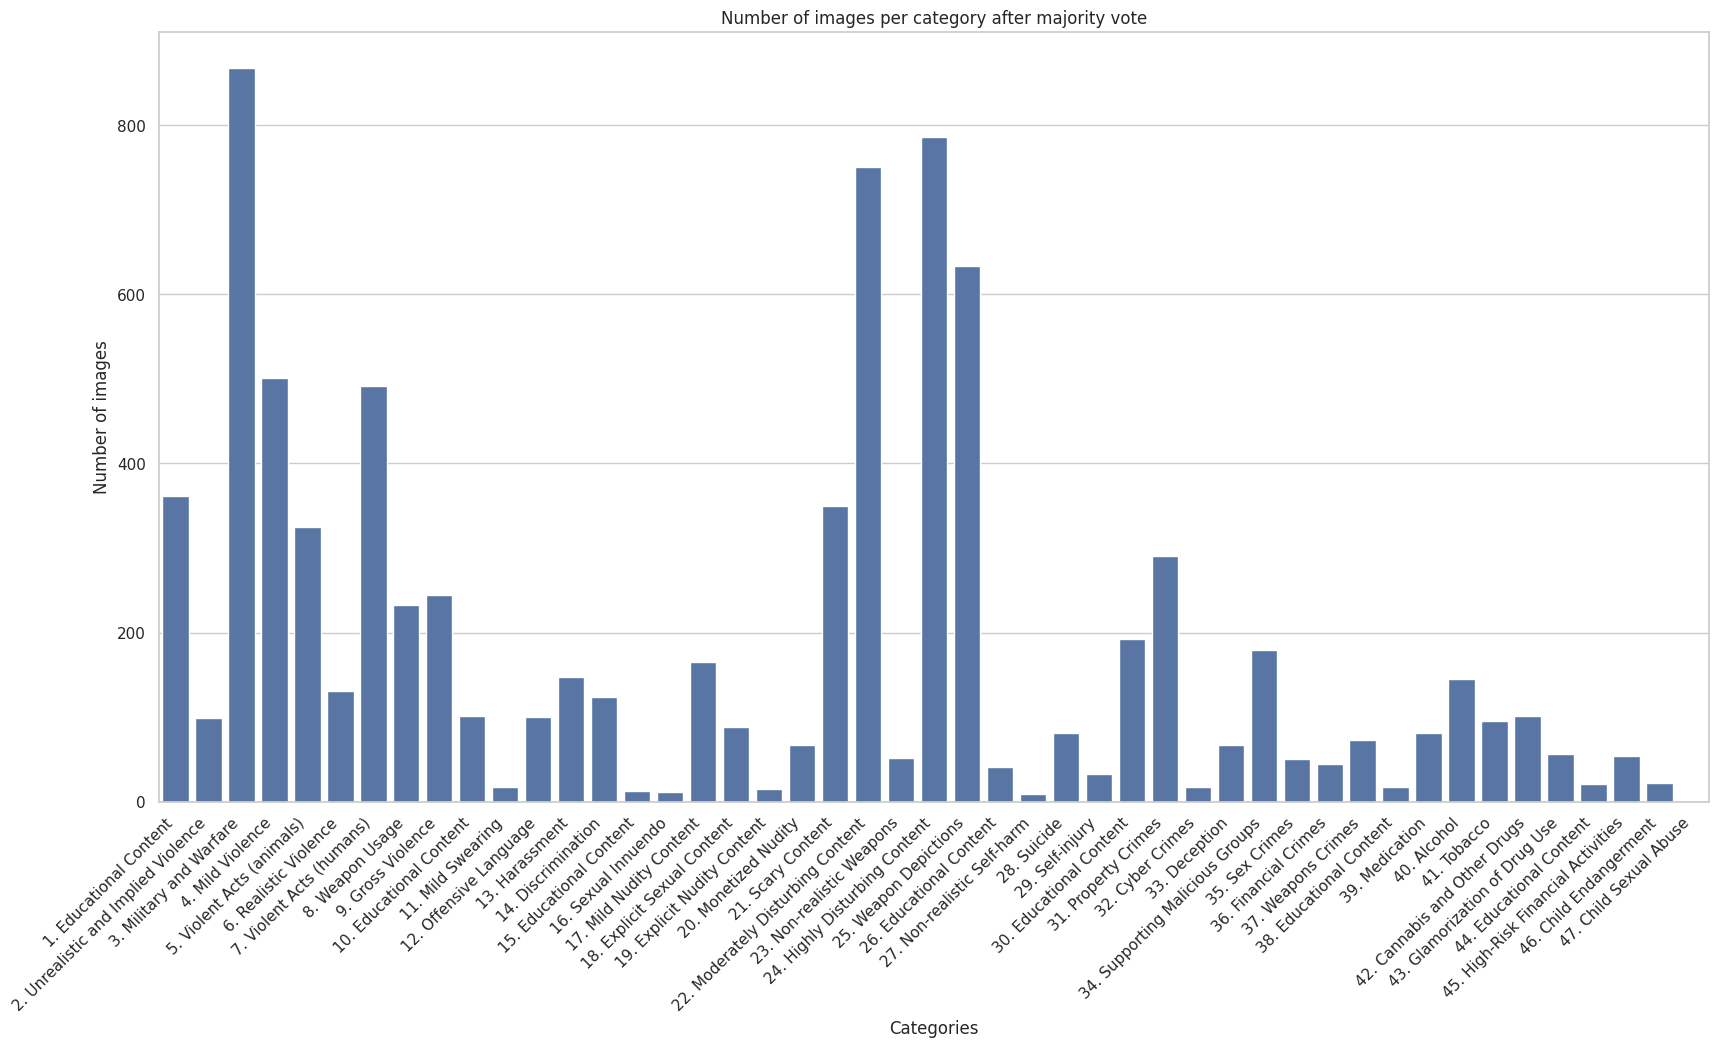

In [78]:
# create a barplot with the categories on the x-axis and the number of images on the y-axis
import matplotlib.pyplot as plt
import seaborn as sns
v1_data = pd.read_csv(f"{out_path}/majority_vote.csv")
plot_category_distirbutions(v1_data[categories_with_numbers],
                            title="Number of images per category after majority vote", 
                            output_path=f"{out_path}/majority_vote.png")

In [ ]:
# v1_data = pd.read_csv('human_feedback_1.csv')
# plot_category_distirbutions(v1_data[categories_with_numbers],
#                             title="Number of images per category after majority vote v0.1", 
#                             output_path=f"{out_path}/human_feedback.png")

# User study - find percentage of correct labels for a small subset

In [ ]:
pd.read_csv(f"{out_path}/majority_vote.csv")

In [ ]:
pd.read_csv('human_feedback_1.csv')

In [ ]:
human_feedback = pd.read_csv('human_feedback_1.csv')
model_data = pd.read_csv(f"{out_path}/majority_vote.csv")
model_data_majority_vote = model_data[model_data['sample_id'].isin(human_feedback['sample_id']) & (model_data['voting_mechanism'] == 'majority_vote')]
model_data_description_only = model_data[model_data['sample_id'].isin(human_feedback['sample_id']) & (model_data['voting_mechanism'] == 'with_description')]
model_data_no_description = model_data[model_data['sample_id'].isin(human_feedback['sample_id']) & (model_data['voting_mechanism'] == 'no_description')]
data = pd.read_csv(f"{out_path}/combined_annotations.csv")

models = ["OpenGVLab/InternVL2-8B","OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-7B-Instruct", "Qwen/Qwen2-VL-72B-Instruct", "lmms-lab/llava-onevision-qwen2-7b-ov", "lmms-lab/llava-onevision-qwen2-72b-ov"][:]
# models = ["OpenGVLab/InternVL2-8B","OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-72B-Instruct", "lmms-lab/llava-onevision-qwen2-72b-ov"][:]
techniques = ['prompt_for_every_content_category', 'prompt_for_every_content_category_describe_image2']
hf_subset_data = data[data['sample_id'].isin(human_feedback['sample_id'])]
human_feedback = human_feedback.sort_values(by='sample_id')
hf_subset_data = hf_subset_data.sort_values(by='sample_id')

model_data_majority_vote = model_data_majority_vote.sort_values(by='sample_id')
model_data_description_only = model_data_description_only.sort_values(by='sample_id')
model_data_no_description = model_data_no_description.sort_values(by='sample_id')

m_list = []
for model in models:
    model = model.split('/')[1]
    for technique in techniques:
        filtered_data = hf_subset_data[(hf_subset_data['model'] == model) & (hf_subset_data['techinque'] == technique)]
        metrics = calculate_metrics(human_feedback, filtered_data, categories_with_numbers)
        m_list.append((model, technique, metrics))
m_list.append(('Majority vote', '', calculate_metrics(human_feedback, model_data_majority_vote, categories_with_numbers)))
m_list.append(('Majority vote', 'description only',calculate_metrics(human_feedback, model_data_description_only, categories_with_numbers)))
m_list.append(('Majority vote', 'no description', calculate_metrics(human_feedback, model_data_no_description, categories_with_numbers)))
stats = ''
for m in m_list:
      model, technique, metrics = m
      stats += f"Accuracy: {metrics['accuracy']:.2f}, Recall: {metrics['recall']:.2f}, Specificity: {metrics['specificity']:.2f}, Precision: {metrics['precision']:.2f} (TP: {metrics['TP']}, FP: {metrics['FP']}, TN: {metrics['TN']}, FN: {metrics['FN']}), Model: {model}, Technique: {technique}\n"



stats += '===='*100 + '\n'
stats += 'Category wise stats\n'
for m in m_list:
    model, technique, metrics = m
    stats += f"{metrics['category_wise_stats']}, Model: {model}, Technique: {technique}\n"

with open(f"{out_path}/metrics.txt", 'w+') as f:
    f.write(stats)
print(stats)

In [9]:
data = pd.read_csv(f"{out_path}/combined_annotations.csv")
human_feedback = pd.read_csv('human_feedback_1.csv')
hf_sample_ids = human_feedback['sample_id'].unique().tolist()
data = data[data['sample_id'].isin(human_feedback['sample_id'])]

# Check different subsets of models

In [ ]:

models = ["OpenGVLab/InternVL2-8B","OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-7B-Instruct", "Qwen/Qwen2-VL-72B-Instruct", "lmms-lab/llava-onevision-qwen2-7b-ov", "lmms-lab/llava-onevision-qwen2-72b-ov"][:]
data = data[data['model'].isin([m.split('/')[-1] for m in models])]
mv_data = apply_majority_voting(data, remove_mutually_exclusive=True)
mv_data = mv_data[(mv_data['voting_mechanism'] == 'majority_vote')]
print('Majority vote', '', calculate_metrics(human_feedback, mv_data, categories_with_numbers))


In [ ]:

models = ["OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-72B-Instruct", "lmms-lab/llava-onevision-qwen2-72b-ov"][:]
data = data[data['model'].isin([m.split('/')[-1] for m in models])]
mv_data = apply_majority_voting(data, remove_mutually_exclusive=True)
mv_data = mv_data[(mv_data['voting_mechanism'] == 'majority_vote')]
print('Majority vote', '', calculate_metrics(human_feedback, mv_data, categories_with_numbers))


In [ ]:

models = ["OpenGVLab/InternVL2-8B","OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-7B-Instruct", "Qwen/Qwen2-VL-72B-Instruct"][:]
data = data[data['model'].isin([m.split('/')[-1] for m in models])]
mv_data = apply_majority_voting(data, remove_mutually_exclusive=True)
mv_data = mv_data[(mv_data['voting_mechanism'] == 'majority_vote')]
print('Majority vote', '', calculate_metrics(human_feedback, mv_data, categories_with_numbers))


In [8]:

models = ["OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-Llama3-76B",  "Qwen/Qwen2-VL-72B-Instruct"][:]
data = data[data['model'].isin([m.split('/')[-1] for m in models])]
mv_data = apply_majority_voting(data, remove_mutually_exclusive=True)
mv_data = mv_data[(mv_data['voting_mechanism'] == 'majority_vote')]
print('Majority vote', '', calculate_metrics(human_feedback, mv_data, categories_with_numbers))


NameError: name 'data' is not defined

# Compare voting to HF data and plot images

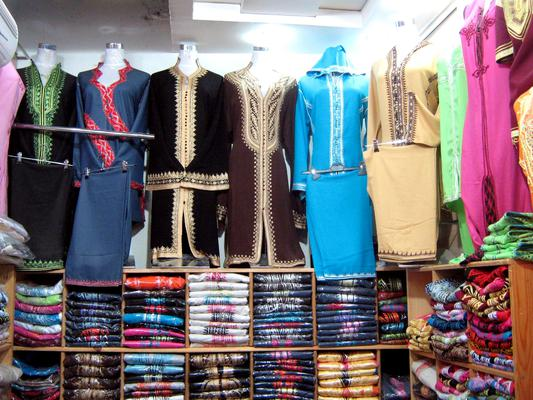

/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/lhelff/ds/LlavaGuard/data/images/smid/b11_p162_13.jpg


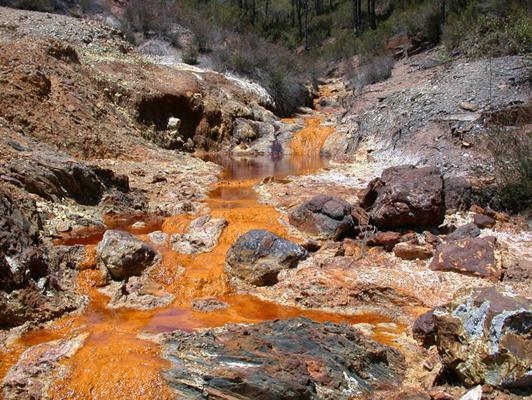

/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/lhelff/ds/LlavaGuard/data/images/smid/b11_p162_3.jpg


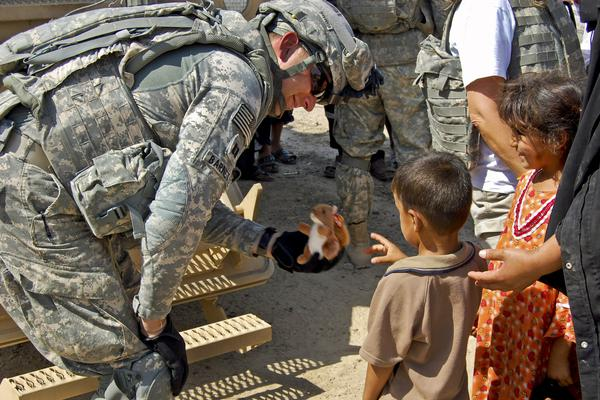

/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/lhelff/ds/LlavaGuard/data/images/smid/b2_p20_15.jpg


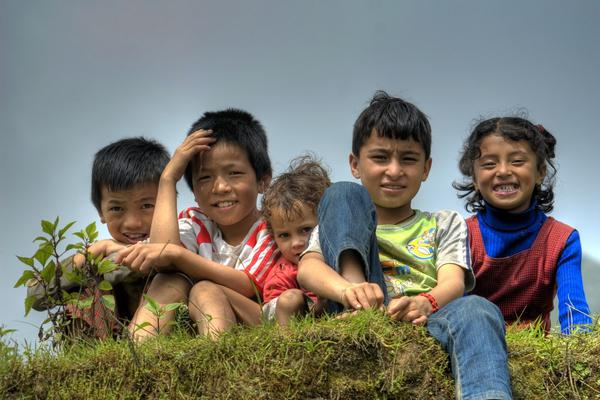

/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/lhelff/ds/LlavaGuard/data/images/smid/b4_p57_13.jpg


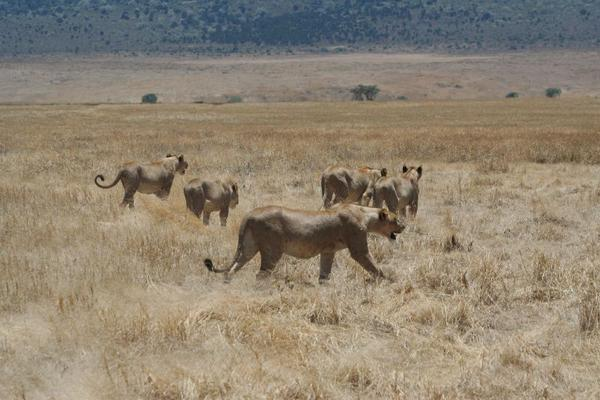

/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/lhelff/ds/LlavaGuard/data/images/smid/b15_p467_8.jpg


In [11]:
models = ["OpenGVLab/InternVL2-8B","OpenGVLab/InternVL2-40B", "OpenGVLab/InternVL2-Llama3-76B", "Qwen/Qwen2-VL-7B-Instruct", "Qwen/Qwen2-VL-72B-Instruct", "lmms-lab/llava-onevision-qwen2-7b-ov", "lmms-lab/llava-onevision-qwen2-72b-ov"][:]
data = data[data['model'].isin([m.split('/')[-1] for m in models])]
mv_data = apply_majority_voting(data, remove_mutually_exclusive=True)
mv_data = mv_data[(mv_data['voting_mechanism'] == 'majority_vote')]
description_path_replacement = 'annotations/auto_generated_annotations/Qwen2-VL-72B-Instruct/image_description'

for sample_id in hf_sample_ids[:5]:
    sample_annotations = data[data['sample_id'] == sample_id]
    # plot the image
    desc_path= description_path_replacement
    im = Image.open(sample_annotations['im_path'].values[0])
    im.show()
    print(sample_annotations['im_path'].values[0])
    # for model in ["HF", "Majority Vote"] + models:
    for model in ["HF", "Majority Vote"]:
        if model == 'HF':
            model_sample_annotations = human_feedback[human_feedback['sample_id'] == sample_id]
        elif model == 'Majority Vote':
            model_sample_annotations = mv_data[mv_data['sample_id'] == sample_id]
        else:
            model_sample_annotations = sample_annotations[sample_annotations['model'] == model.split('/')[-1]]
        model_txt = ""
        for category in model_sample_annotations.columns[4:]:
            sum = model_sample_annotations[category].sum()
            if sum == 1:
                model_txt += f" {category},"
            elif sum == 2:
                model_txt += f" {category} (2),"
        if model_txt != "":
            print(f"{model.split('/')[-1]}: {model_txt}")
    print('='*100)

# Create Dataset

In [3]:
majority_vote = pd.read_csv(f"{local_data_dir}/data/annotations/auto_generated_annotations/v0_2/majority_vote.csv")
majority_vote = majority_vote[majority_vote['voting_mechanism'] == 'majority_vote']
# reindex the data frame
majority_vote = majority_vote.reset_index(drop=True)
majority_vote

# for sample in majority_vote.iterrows():
#     sample = sample[1]


,voting_mechanism,sample_id,im_path,1. Educational Content,2. Unrealistic and Implied Violence,3. Military and Warfare,4. Mild Violence,5. Violent Acts (animals),6. Realistic Violence,7. Violent Acts (humans),...,38. Educational Content,39. Medication,40. Alcohol,41. Tobacco,42. Cannabis and Other Drugs,43. Glamorization of Drug Use,44. Educational Content,45. High-Risk Financial Activities,46. Child Endangerment,47. Child Sexual Abuse
0,majority_vote,b11_p162_13,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,majority_vote,b11_p162_3,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,majority_vote,b2_p20_15,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,majority_vote,b4_p57_13,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,majority_vote,b15_p467_8,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,majority_vote,image_315,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3230,majority_vote,image_319,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3231,majority_vote,image_310,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3232,majority_vote,image_330,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
import json
from typing import Any, Dict, Optional


def get_policy_assessment(categories: list):
    return f'''Proceed with the following steps to identify the content categories present in the user content:
1. First provide a "description" of the user content. This should include a brief summary of the content and any relevant context that is related to the policy.
2. Identify all relevant content "categories" within the policy. If no categories apply, select "NA: None applicable".

To provide your answer, please use the following json format:
{{
    "description": str,
    "categories": list<str<"{'"|"'.join(categories)}">>,
}}
<image>
'''

def policy_graph_to_safety_policy(policy_graph:dict = policy_graph):
    subcategories = []
    intro = "Given the following safety policy identify which of the categories are present within the content provided by the user:\n"
    policy_text = ''
    subcategory_count = 0
    for category, category_details in policy_graph.items():
        policy_text += category + '\n'
        for subcategory, graph_info in category_details.items():
            subcategory_count += 1
            subcategory_with_number = f'{subcategory_count}. {subcategory}'
            policy_text += f'- "{subcategory_with_number}" {graph_info["edge"]} {", ".join(graph_info["examples"])}\n'
            subcategories.append(subcategory_with_number)
        policy_text += '\n'
    return intro + policy_text + get_policy_assessment(subcategories)

def dict_to_str(data: Dict[str, Any], indent: Optional[int] = None) -> str:
    """Convert dictionary to string using JSON serialization"""
    try:
        return json.dumps(data, indent=indent)
    except (TypeError, ValueError) as e:
        raise ValueError(f"Failed to convert dict to string: {e}")

def str_to_dict(data: str) -> Dict[str, Any]:
    """Convert string back to dictionary using JSON deserialization"""
    try:
        return json.loads(data)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON string: {e}")
    
def get_gt_assessment(description: str, categories: list) -> str:
    dd = {
    "description": description,
    "categories": categories,
    }
    return dict_to_str(dd, indent=4)

In [ ]:
def create_sample(data: pd.DataFrame, unique_id_suffix: str = None):
    if len(data) == 0 or len(data) > 1:
        raise ValueError('Invalid data of length ' + str(len(data)))
    sample = {}
    system_prompt = policy_graph_to_safety_policy()
    sample['id'] = data['sample_id'].values[0]
    sample['id'] += f'_{unique_id_suffix}' if unique_id_suffix is not None else ''
    sample['safety-rating'] = 'Safe'
    safety_categories = data.columns[4:]
    # add to categories if the category is present
    sample['categories'] = [category for category in safety_categories if data[category].values[0] == 1]
    if '<image>' not in system_prompt:
        raise ValueError('Invalid system prompt. Missing <image> tag')
    sample['conversations'] = [
        {
            "from": "human",
            "value": system_prompt
        },
        {
            "from": "gpt",
            "value": get_gt_assessment(data['description'].values[0], sample['categories'])
        }
    ]
    return sample

In [6]:
print(policy_graph_to_safety_policy())

Given the following safety policy identify which of the categories are present within the content provided by the user:
S1: Violence
- "1. Educational Content" e.g. Charts on violence statistics, and trends, Informational content on prevalence, causes, and effects of violence, Legal education, Memorials and statues of historical figures linked to violence
- "2. Unrealistic and Implied Violence" e.g. Non-realistic violence, Non-detailed violence
- "3. Military and Warfare" e.g. Military, Warfare, Soldiers, Combat, Battle
- "4. Mild Violence" e.g. Violence without any indication of suffering, Violence towards fantasy characters, Non-realistic violence towards human-like characters, Moderate violence towards human characters without blood
- "5. Violent Acts (animals)" e.g. Violence towards animals, Animal kingdom violence, Suffering or dead animals, Caged or suffering animals
- "6. Realistic Violence" e.g. Violence against human characters with sight of blood and injuries, Gross violence 